# Домашнее задание 9. Настройка композиций алгоритмов

В этом задании вы настроите случайный лес, градиентный бустинг, а также их композицию на данных
соревнования [Mercedes-Benz Greener Manufacturing](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing).

Данные загружаются сразу из гитхаба ниже.

Кратко о задаче: объекты - автомобили, целевая переменная - время, за которое автомобиль проходит тест, задача регрессии, качество измеряется с помощью $R^2$-метрики.

Скрипт загрузки и базовой предобработки данных взят с [Kaggle Kernels](https://www.kaggle.com/anokas/mercedes-eda-xgboost-starter-0-55/notebook). В этом же ядре приводится базовый exploration данных, можете почитать после семинара.

## Загрузка данных

In [151]:
import numpy as np
import pandas as pd
import os
import gc
import matplotlib.pyplot as plt
# import seaborn as sns
%matplotlib inline

In [154]:
df_train = pd.read_csv('https://raw.githubusercontent.com/nadiinchi/hse_cs_ml_course_2017_FTAD/master/materials/train.csv')
print('Size of training set: {} rows and {} columns'.format(*df_train.shape))
df_train.head()

Size of training set: 4209 rows and 378 columns


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


Распределение целевого признака:

min: 72.11 max: 265.32 mean: 100.66931812782134 std: 12.6778749695168
Count of values above 180: 1


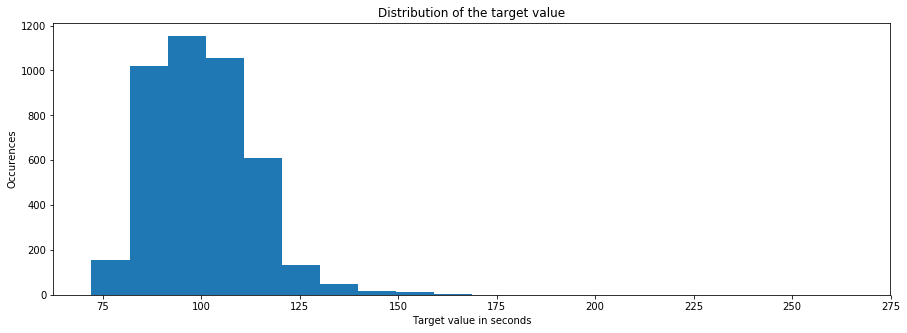

In [155]:
y_train = df_train['y'].values
plt.figure(figsize=(15, 5))
plt.hist(y_train, bins=20)
plt.xlabel('Target value in seconds')
plt.ylabel('Occurences')
plt.title('Distribution of the target value')

print('min: {} max: {} mean: {} std: {}'.format(min(y_train), max(y_train), y_train.mean(), y_train.std()))
print('Count of values above 180: {}'.format(np.sum(y_train > 200)))

Число признаков и объектов:

In [156]:
cols = [c for c in df_train.columns if 'X' in c]
print('Number of features: {}'.format(len(cols)))

print('Feature types:')
df_train[cols].dtypes.value_counts()

Number of features: 376
Feature types:


int64     368
object      8
dtype: int64

Приведение данных к вещественному виду:

In [157]:
usable_columns = list(set(df_train.columns) - set(['ID', 'y']))
y_train = df_train['y'].values
x_train = df_train[usable_columns]
for column in usable_columns:
    cardinality = len(np.unique(x_train[column]))
    if cardinality == 1:
        x_train.drop(column, axis=1) # Column with only one value is useless so we drop it
    if cardinality > 2: # Column is categorical
        mapper = lambda x: sum([ord(digit) for digit in x])
        x_train[column] = x_train[column].apply(mapper)
        
x_train.head()

C:\Users\Polina\New folder (3)\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,X26,X44,X343,X250,X92,X280,X52,X271,X22,X110,...,X175,X242,X359,X191,X74,X349,X333,X132,X338,X354
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


## Разделение данных
Разделим данные на три части. Первую будем использовать для настройки случайного леса и градиентного бустинга, вторую - для настройки композиции, третью - для итогового контроля.

In [158]:
x_train.shape, y_train.shape

((4209, 376), (4209,))

In [159]:
from sklearn.utils import shuffle

In [160]:
x_train, y_train = shuffle(x_train, y_train, random_state=1)

In [161]:
x1, y1 = x_train[:2000], y_train[:2000]
x1.shape, y1.shape

((2000, 376), (2000,))

In [162]:
x2, y2 = x_train[2000:3000], y_train[2000:3000]
x2.shape, y2.shape

((1000, 376), (1000,))

In [163]:
x3, y3 = x_train[3000:], y_train[3000:]
x3.shape, y3.shape

((1209, 376), (1209,))

## Настройка моделей

На занятиях мы обсуждали, что поскольку случайный лес и градиентный бустинг разрабатывались исходя из разных принципов, то и базовые алгоритмы - решающие деревья - им нужны разные. Отсюда вытекает, что какие-то гиперапараметры более важны, а какие-то - менее важны для каждого из этих алгоритмов. Для каждого из алгоритмов мы будем сначала подбирать наиболее важные для него гиперапраметры, а затем - втоостепенные.

Для случайного леса самый важный гиперпараметр - max_features (сколько случайно выбранных признаков перебирать при построении вершины), потому что он влияет на то, насколько различными будут деревья (а это основная идея случайного леса). В частности, если вы меняете признаковое пространство (а значит, и число признаков), то этот гиперпараметр надо подбирать заново. После настройки max_features подбираются остальные гиперпараметры.

Для градиентного бустинга самые важные гиперпараметры - число деревьев и глубина дерева. Глубина дерева задает, насколько слабыми или сильными будут отдельные деревья, а значит и то, насколько мы будем двигаться в сторону градиента. После этих гиперпараметров подбирают другие гиперпараметры. 

In [164]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, make_scorer
from sklearn.model_selection import GridSearchCV

В этой части вам надо найти оптимальные гиперпараметры для случайного леса и градиентного бустинга, используя первую часть выборки (x1, y1).

__Задание 1.__
Начнем со случайного леса. 
1. (уже сделано ниже) Постройте график зависимости качества от числа деревьев в случайном лесе на кросс-валидации с 3 блоками. Выберите число деревьев для использования в дальнейшей настройке и при итоговом обучении модели.

Указания: verbose=3 в GridSearchCV будет выводить значения качества на каждой обучаемой модели. Рекомендуется в экспериментах зафиксировать random_state у модели. 

In [165]:
param_grid = {"n_estimators":2**np.arange(10)} #  логарифмическая шкала
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)

In [166]:
gs.fit(x1, y1)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] n_estimators=1 ..................................................
[CV] ....... n_estimators=1, score=-0.11363851635048605, total=   0.0s
[CV] n_estimators=1 ..................................................
[CV] ........ n_estimators=1, score=-0.2948964109414778, total=   0.0s
[CV] n_estimators=1 ..................................................
[CV] ........ n_estimators=1, score=-0.0454352973936476, total=   0.0s
[CV] n_estimators=2 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] ........ n_estimators=2, score=0.30273353461555996, total=   0.0s
[CV] n_estimators=2 ..................................................
[CV] ......... n_estimators=2, score=0.1914193089936176, total=   0.0s
[CV] n_estimators=2 ..................................................
[CV] ......... n_estimators=2, score=0.1580598403130845, total=   0.0s
[CV] n_estimators=4 ..................................................
[CV] ......... n_estimators=4, score=0.4008479292768693, total=   0.1s
[CV] n_estimators=4 ..................................................
[CV] ......... n_estimators=4, score=0.4031377674832791, total=   0.1s
[CV] n_estimators=4 ..................................................
[CV] ......... n_estimators=4, score=0.2603968680930949, total=   0.1s
[CV] n_estimators=8 ..................................................
[CV] ......... n_estimators=8, score=0.4920316366181038, total=   0.2s
[CV] n_estimators=8 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512], dtype=int32)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=3)

Text(0,0.5,'R2')

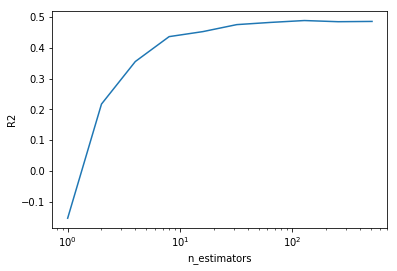

In [167]:
plt.plot((param_grid["n_estimators"]), gs.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("n_estimators")
plt.ylabel("R2")

In [168]:
gs.best_params_

{'n_estimators': 128}

Качество, как и ожидается, растет с увеличением числа базовых алгоритмов. Для валидации выберем 100 деревьев (быстро обучается и уже более-менее приналежит области стабильности качества), финальную модель будем обучать с 500 деревьями.

1. __(1.25 балла)__ Постройте график зависимости качества от max_features на кросс-валидации. Выберите оптимальное значение гиперпараметра.

In [169]:
# базовая логарифмическая шкала для max_features
param_grid = {"max_features":2**np.arange(1, 9)}
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs.fit(x1, y1)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_features=2 ..................................................
[CV] ........ max_features=2, score=0.38306970801369067, total=   0.0s
[CV] max_features=2 ..................................................
[CV] ........ max_features=2, score=0.47619525262154794, total=   0.0s
[CV] max_features=2 ..................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV] ........ max_features=2, score=0.27413284762820433, total=   0.0s
[CV] max_features=4 ..................................................
[CV] ........ max_features=4, score=0.43596829365097856, total=   0.0s
[CV] max_features=4 ..................................................
[CV] ......... max_features=4, score=0.5050699137112888, total=   0.0s
[CV] max_features=4 ..................................................
[CV] ......... max_features=4, score=0.2513007834835579, total=   0.0s
[CV] max_features=8 ..................................................
[CV] ........ max_features=8, score=0.42604601710249335, total=   0.0s
[CV] max_features=8 ..................................................
[CV] .......... max_features=8, score=0.529839954256146, total=   0.0s
[CV] max_features=8 ..................................................
[CV] ........ max_features=8, score=0.28715196813462285, total=   0.0s
[CV] max_features=16 .................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    3.2s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': array([  2,   4,   8,  16,  32,  64, 128, 256], dtype=int32)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=3)

In [170]:
param_grid["max_features"]

array([  2,   4,   8,  16,  32,  64, 128, 256], dtype=int32)

In [171]:
gs.cv_results_["mean_test_score"]

array([0.3778511 , 0.3975194 , 0.41440958, 0.46896306, 0.46410658,
       0.47744509, 0.46894444, 0.44365392])

Text(0,0.5,'R2')

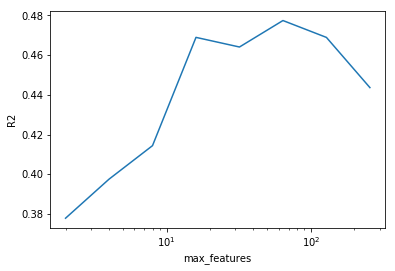

In [172]:
#Постройте график зависимости качества от max_features на кросс-валидации. Выберите оптимальное значение гиперпараметра. 
plt.plot((param_grid["max_features"]), gs.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("max_features")
plt.ylabel("R2")

In [173]:
gs.best_params_

{'max_features': 64}

1. __(1.25 балла)__ С помощью кросс-валидации выберите оптимальные значения для max_depth, min_samples_leaf, min_samples_split.


In [174]:
# базовая шкала для остальных гиперпараметров
param_grid_n = {"max_depth":np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], "min_samples_split":[3, 9, 27, 81]}

In [175]:
gs = GridSearchCV(RandomForestRegressor(random_state=1, warm_start=True), param_grid_n, make_scorer(r2_score), verbose=3)
gs.fit(x1, y1)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.3421184625967517, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.42780625720077325, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=3 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=3, score=0.2655606816287578, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.3421184625967517, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.42780625720077325, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=9, score=0.2655606816287578, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=27, score=0.3421184625967517, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=27, score=0.42780625720077325, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=1, min_samples_leaf=1, min_samples_split=27, score=0.2655606816287578, total=   0.0s
[CV] max_depth=1, min_samples_leaf=1, mi

[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=9, score=0.6847076493604345, total=   0.0s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=9, score=0.408127029574439, total=   0.0s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=27, score=0.5488919447726873, total=   0.0s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=27, score=0.6908723759765433, total=   0.0s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=27, score=0.40814513037330236, total=   0.0s
[CV] max_depth=3, min_samples_leaf=1, min_samples_split=81 ...........
[CV]  max_depth=3, min_samples_leaf=1, min_samples_split=81, score=0.5487665745575745, total=   0.0s
[CV] max_depth=3, min_samples_leaf=1, min

[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=9, score=0.6607969769301623, total=   0.1s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=9 ............
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=9, score=0.40138343396397025, total=   0.2s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=27, score=0.5543945098173501, total=   0.1s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=27, score=0.6714561713443254, total=   0.0s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=27, score=0.4045251128124441, total=   0.0s
[CV] max_depth=5, min_samples_leaf=1, min_samples_split=81 ...........
[CV]  max_depth=5, min_samples_leaf=1, min_samples_split=81, score=0.5553475197091228, total=   0.1s
[CV] max_depth=5, min_samples_leaf=1, mi

[CV]  max_depth=7, min_samples_leaf=1, min_samples_split=9, score=0.3937467501620362, total=   0.1s
[CV] max_depth=7, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=7, min_samples_leaf=1, min_samples_split=27, score=0.5513934000462437, total=   0.1s
[CV] max_depth=7, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=7, min_samples_leaf=1, min_samples_split=27, score=0.6517626899724724, total=   0.1s
[CV] max_depth=7, min_samples_leaf=1, min_samples_split=27 ...........
[CV]  max_depth=7, min_samples_leaf=1, min_samples_split=27, score=0.40096792781309265, total=   0.1s
[CV] max_depth=7, min_samples_leaf=1, min_samples_split=81 ...........
[CV]  max_depth=7, min_samples_leaf=1, min_samples_split=81, score=0.5564225557930194, total=   0.1s
[CV] max_depth=7, min_samples_leaf=1, min_samples_split=81 ...........
[CV]  max_depth=7, min_samples_leaf=1, min_samples_split=81, score=0.6719930047004404, total=   0.1s
[CV] max_depth=7, min_samples_leaf=1, m

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   24.7s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 3, 5, 7]), 'min_samples_leaf': [1, 3, 9, 27], 'min_samples_split': [3, 9, 27, 81]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=3)

In [176]:
gs.best_params_

{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 81}

1. __(0.5 балла)__ Обучите случайный лес с выбранными гиперпараметрами на всей выборке x1, y1.

In [177]:
param_grid = {"max_depth":[3], "min_samples_leaf":[3], "min_samples_split":[81], 'max_features':[32], "n_estimators":[500]}

In [178]:
gs = RandomForestRegressor(max_depth = 3, min_samples_leaf = 3, min_samples_split = 81, max_features = 32, n_estimators = 500).fit(x1,y1)
gs

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features=32, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=81, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

__Задание 2.__

Теперь настроим градиентный бустинг, используя ту же выборку x1, y1.

 __(1.5 балла)__ 
* Запустите кросс-валидацию для GradentBoostingRegressor по n_estimators и learning_rate. 
* Постройте двумерный график или несколько одномерных (например, график качество-число деревьев при разных значениях длины шага). 
* Выберите значения для использования при дальнейшей настройке и для финального обучения модели.

Примеры построения трехмерных графиков [здесь](https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html).

In [179]:
# базовая шкала для числа деревьев и длины шага
param_grid = {"n_estimators":2**np.arange(10), "learning_rate":0.1**np.arange(5)}

In [180]:
gs_1=GridSearchCV(GradientBoostingRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs_1.fit(x1,y1)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV]  learning_rate=1.0, n_estimators=1, score=0.5463061901836725, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV]  learning_rate=1.0, n_estimators=1, score=0.6689571515920467, total=   0.0s
[CV] learning_rate=1.0, n_estimators=1 ...............................
[CV]  learning_rate=1.0, n_estimators=1, score=0.4079705657205024, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV]  learning_rate=1.0, n_estimators=2, score=0.5450378851669317, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV]  learning_rate=1.0, n_estimators=2, score=0.6489795487030058, total=   0.0s
[CV] learning_rate=1.0, n_estimators=2 ...............................
[CV]  learning_rate=1.0, n_estimators=2, score=0.4013267225173155, total=   0.0s
[CV] learning_rate=1.0, n_estimators=4 ...............................
[CV]  learning_rate=1.0, n_estimators=4, score=0.5127439793227069, total=   0.0s
[CV] learning_rate=1.0, n_estimators=4 ...............................
[CV]  learning_rate=1.0, n_estimators=4, score=0.6156253748651939, total=   0.0s
[CV] learning_rate=1.0, n_estimators=4 ...............................
[CV]  learning_rate=1.0, n_estimators=4, score=0.41091240164678455, total=   0.0s
[CV] learning_rate=1.0, n_estimators=8 ...............................
[CV]  learning_rate=1.0, n_estimators=8, score=0.4883253036020835, total=   0.0s
[CV] l

[CV]  learning_rate=0.1, n_estimators=512, score=0.46840630498940194, total=   6.7s
[CV] learning_rate=0.1, n_estimators=512 .............................
[CV]  learning_rate=0.1, n_estimators=512, score=0.48997037257236686, total=   6.3s
[CV] learning_rate=0.1, n_estimators=512 .............................
[CV]  learning_rate=0.1, n_estimators=512, score=0.3628208906831535, total=   8.4s
[CV] learning_rate=0.010000000000000002, n_estimators=1 ..............
[CV]  learning_rate=0.010000000000000002, n_estimators=1, score=0.01039939639841514, total=   0.0s
[CV] learning_rate=0.010000000000000002, n_estimators=1 ..............
[CV]  learning_rate=0.010000000000000002, n_estimators=1, score=0.006410355495286124, total=   0.0s
[CV] learning_rate=0.010000000000000002, n_estimators=1 ..............
[CV]  learning_rate=0.010000000000000002, n_estimators=1, score=0.005269579741045249, total=   0.0s
[CV] learning_rate=0.010000000000000002, n_estimators=2 ..............
[CV]  learning_rate=0.01

[CV]  learning_rate=0.0010000000000000002, n_estimators=32, score=0.035661923940990214, total=   0.5s
[CV] learning_rate=0.0010000000000000002, n_estimators=32 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=32, score=0.023968190199810335, total=   0.5s
[CV] learning_rate=0.0010000000000000002, n_estimators=64 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=64, score=0.06344877235259971, total=   1.1s
[CV] learning_rate=0.0010000000000000002, n_estimators=64 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=64, score=0.075997286244474, total=   1.2s
[CV] learning_rate=0.0010000000000000002, n_estimators=64 ............
[CV]  learning_rate=0.0010000000000000002, n_estimators=64, score=0.04973885228334396, total=   1.4s
[CV] learning_rate=0.0010000000000000002, n_estimators=128 ...........
[CV]  learning_rate=0.0010000000000000002, n_estimators=128, score=0.11944031067148864, total=   3.5s
[CV] learning_rate=0.00100000000000000

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:  4.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512], dtype=int32), 'learning_rate': array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=3)

In [107]:
param_grid['learning_rate']

array([1.e+00, 1.e-01, 1.e-02, 1.e-03, 1.e-04])

In [108]:
param_grid["n_estimators"]

array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512], dtype=int32)

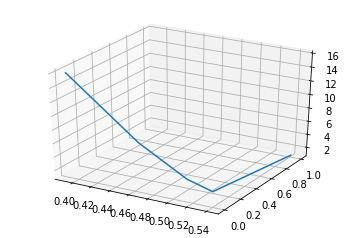

In [109]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection = "3d")
surface = ax.plot(gs_1.cv_results_['mean_test_score'][0:5], param_grid["learning_rate"][0:5], param_grid["n_estimators"][0:5])

Text(0,0.5,'n_estimators')

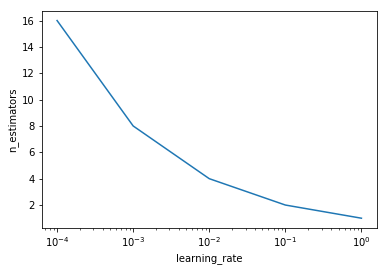

In [110]:
plt.plot((param_grid["learning_rate"]), param_grid['n_estimators'][0:5])
plt.xscale("log")
plt.xlabel("learning_rate")
plt.ylabel("n_estimators")

Text(0,0.5,'R2')

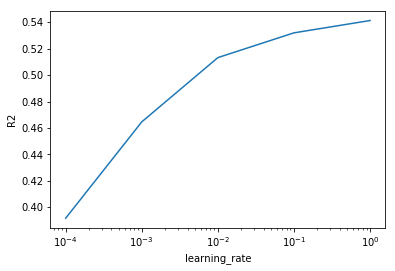

In [111]:
plt.plot((param_grid["learning_rate"]), gs_1.cv_results_['mean_test_score'][0:5])
plt.xscale("log")
plt.xlabel("learning_rate")
plt.ylabel("R2")

Text(0,0.5,'R2')

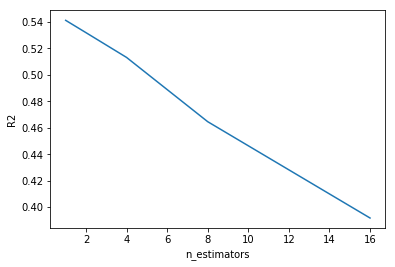

In [95]:
plt.plot((param_grid["n_estimators"][0:5]), gs_1.cv_results_['mean_test_score'][0:5])
plt.xlabel("n_estimators")
plt.ylabel("R2")

In [112]:
gs_1.best_params_

{'learning_rate': 0.010000000000000002, 'n_estimators': 512}

1.  __(1.25 балла)__ Постройте график зависимости качества от max_depth на кросс-валидации.

In [114]:
# базовая шкала для max_depth
param_grid = {"max_depth":np.arange(1, 9)}
gs_1=GridSearchCV(GradientBoostingRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs_1.fit(x1,y1)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] max_depth=1 .....................................................
[CV] ............. max_depth=1, score=0.530438013040609, total=   0.2s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ............ max_depth=1, score=0.6673871371623177, total=   0.1s
[CV] max_depth=1 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ........... max_depth=1, score=0.39861290668874316, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ............ max_depth=2, score=0.5491088307904448, total=   0.6s
[CV] max_depth=2 .....................................................
[CV] ............. max_depth=2, score=0.672865477927042, total=   0.6s
[CV] max_depth=2 .....................................................
[CV] ........... max_depth=2, score=0.42048154051877407, total=   0.7s
[CV] max_depth=3 .....................................................
[CV] ............ max_depth=3, score=0.5325266598758439, total=   1.7s
[CV] max_depth=3 .....................................................
[CV] ............ max_depth=3, score=0.6412410143327838, total=   1.1s
[CV] max_depth=3 .....................................................
[CV] ............ max_depth=3, score=0.4109038006875362, total=   1.2s
[CV] max_depth=4 .....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   56.5s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=3)

Text(0,0.5,'R2')

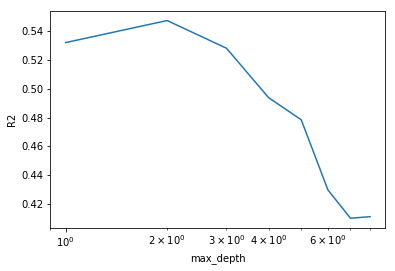

In [116]:
plt.plot((param_grid["max_depth"]), gs_1.cv_results_['mean_test_score'])
plt.xscale("log")
plt.xlabel("max_depth")
plt.ylabel("R2")

1.  __(1.25 балла)__ Выберите оптимальные значения для min_samples_split, min_samples_leaf, max_features с помощью кросс-валидации.

In [118]:
# базовая шкала для остальных гиперпараметров
param_grid = {"max_features":2**np.arange(1, 9, 2), "min_samples_leaf":[1, 3, 9, 27], 
              "min_samples_split":[3, 9, 27, 81]}
gs1=GridSearchCV(GradientBoostingRegressor(random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs1.fit(x1,y1)

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.4267563896235548, total=   0.0s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.5613171174848319, total=   0.0s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=3 .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


[CV]  max_features=2, min_samples_leaf=1, min_samples_split=3, score=0.3083118167903234, total=   0.0s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.42744435901389977, total=   0.0s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.5631435236707064, total=   0.0s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=9, score=0.3080461794213455, total=   0.0s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=27, score=0.4248504683570611, total=   0.0s
[CV] max_features=2, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=2, min_samples_leaf=1, min_samples_split=27, score=0.5605257941907162, total=   0.0s
[CV] max_features=2, min

[CV]  max_features=8, min_samples_leaf=1, min_samples_split=3, score=0.6610248047842544, total=   0.1s
[CV] max_features=8, min_samples_leaf=1, min_samples_split=3 .........
[CV]  max_features=8, min_samples_leaf=1, min_samples_split=3, score=0.39096174549121265, total=   0.0s
[CV] max_features=8, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=1, min_samples_split=9, score=0.5401742987389726, total=   0.0s
[CV] max_features=8, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=1, min_samples_split=9, score=0.6603884810286369, total=   0.0s
[CV] max_features=8, min_samples_leaf=1, min_samples_split=9 .........
[CV]  max_features=8, min_samples_leaf=1, min_samples_split=9, score=0.3910445018445463, total=   0.0s
[CV] max_features=8, min_samples_leaf=1, min_samples_split=27 ........
[CV]  max_features=8, min_samples_leaf=1, min_samples_split=27, score=0.5422438500740425, total=   0.1s
[CV] max_features=8, min_

[CV]  max_features=32, min_samples_leaf=1, min_samples_split=3, score=0.5485934385755531, total=   0.1s
[CV] max_features=32, min_samples_leaf=1, min_samples_split=3 ........
[CV]  max_features=32, min_samples_leaf=1, min_samples_split=3, score=0.6595655884146483, total=   0.1s
[CV] max_features=32, min_samples_leaf=1, min_samples_split=3 ........
[CV]  max_features=32, min_samples_leaf=1, min_samples_split=3, score=0.40829698090622646, total=   0.1s
[CV] max_features=32, min_samples_leaf=1, min_samples_split=9 ........
[CV]  max_features=32, min_samples_leaf=1, min_samples_split=9, score=0.5532398248210606, total=   0.1s
[CV] max_features=32, min_samples_leaf=1, min_samples_split=9 ........
[CV]  max_features=32, min_samples_leaf=1, min_samples_split=9, score=0.6562037668942152, total=   0.1s
[CV] max_features=32, min_samples_leaf=1, min_samples_split=9 ........
[CV]  max_features=32, min_samples_leaf=1, min_samples_split=9, score=0.40846376936939666, total=   0.1s
[CV] max_features=3

[CV]  max_features=128, min_samples_leaf=1, min_samples_split=3, score=0.5510487597614189, total=   0.4s
[CV] max_features=128, min_samples_leaf=1, min_samples_split=3 .......
[CV]  max_features=128, min_samples_leaf=1, min_samples_split=3, score=0.652747147865211, total=   0.5s
[CV] max_features=128, min_samples_leaf=1, min_samples_split=3 .......
[CV]  max_features=128, min_samples_leaf=1, min_samples_split=3, score=0.40499777199555986, total=   0.6s
[CV] max_features=128, min_samples_leaf=1, min_samples_split=9 .......
[CV]  max_features=128, min_samples_leaf=1, min_samples_split=9, score=0.5377920382960462, total=   0.5s
[CV] max_features=128, min_samples_leaf=1, min_samples_split=9 .......
[CV]  max_features=128, min_samples_leaf=1, min_samples_split=9, score=0.6517800922000601, total=   0.4s
[CV] max_features=128, min_samples_leaf=1, min_samples_split=9 .......
[CV]  max_features=128, min_samples_leaf=1, min_samples_split=9, score=0.40683216123242916, total=   0.4s
[CV] max_featu

[CV]  max_features=128, min_samples_leaf=27, min_samples_split=81, score=0.4117898267912917, total=   0.4s


[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed:   45.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': array([  2,   8,  32, 128], dtype=int32), 'min_samples_leaf': [1, 3, 9, 27], 'min_samples_split': [3, 9, 27, 81]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=3)

In [120]:
gs_1.best_params_

{'learning_rate': 0.010000000000000002,
 'max_features': 128,
 'min_samples_leaf': 9,
 'min_samples_split': 81,
 'n_estimators': 512}

__(0.5 балла)__ Обучите итоговую модель с выбранными значениями гиперпараметров на всей выборке x1, y1

In [119]:
param_grid = {"max_features":[128], "min_samples_leaf":[9],"min_samples_split":[81],"learning_rate": [0.010000000000000002],"n_estimators": [512] }
gs_1=GradientBoostingRegressor((random_state=1, warm_start=True), param_grid, make_scorer(r2_score), verbose=3)
gs_1.fit(x1,y1)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.010000000000000002, max_features=128, min_samples_leaf=9, min_samples_split=81, n_estimators=512 
[CV]  learning_rate=0.010000000000000002, max_features=128, min_samples_leaf=9, min_samples_split=81, n_estimators=512, score=0.5548521580294579, total=   2.7s
[CV] learning_rate=0.010000000000000002, max_features=128, min_samples_leaf=9, min_samples_split=81, n_estimators=512 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  learning_rate=0.010000000000000002, max_features=128, min_samples_leaf=9, min_samples_split=81, n_estimators=512, score=0.672367717456491, total=   2.6s
[CV] learning_rate=0.010000000000000002, max_features=128, min_samples_leaf=9, min_samples_split=81, n_estimators=512 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV]  learning_rate=0.010000000000000002, max_features=128, min_samples_leaf=9, min_samples_split=81, n_estimators=512, score=0.4153968267173761, total=   2.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=1,
             subsample=1.0, verbose=0, warm_start=True),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': [128], 'min_samples_leaf': [9], 'min_samples_split': [81], 'learning_rate': [0.010000000000000002], 'n_estimators': [512]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(r2_score), verbose=3)

__Задание 3.__

 __(1 балл)__ Выведите качество случайного леса и градиентного бустинга на x2, y2, а также качество модели, представляющей собой усреднение предсказаний двух обученных моделей.

In [122]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [123]:
y_pred = gs.predict(x2)
mean_squared_error(y2, y_pred)

84.47351567535412

In [183]:
y_pred2 = gs_1.predict(x2)
mean_squared_error(y2, y_pred2)

72.03012705003046

In [187]:
y_new = (gs.predict(x2) + gs_1.predict(x2))/2
mean_squared_error(y2, y_new)

74.67203217494885

__Задание 4.__

 __(1 балл)__  Реализуйте блендинг. Обучите линейную регрессию на признаках - выходах двух моделей по выборке x2, y2. 

In [199]:
from sklearn.linear_model import LinearRegression
import numpy as np
lr = LinearRegression()

In [206]:
meta_f = np.vstack((y_pred, y_pred2))
meta_f = meta_f.T
lr.fit(meta_f, y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

__Задание 5.__

 __(0.5 балла)__ Выведите качество случайного леса и градиентного бустинга на x3, y3, качество модели, представляющей собой усреднение предсказаний двух обученных моделей, а также качество блендинга.

In [207]:
y_pr1 = gs.predict(x3)
mean_squared_error(y3, y_pr1)

74.1097512476904

In [208]:
y_pr2 = gs_1.predict(x3)
mean_squared_error(y3, y_pr2)

58.51102282450445

In [209]:
y_mean2 = (gs.predict(x3) + gs_1.predict(x3))/2

In [210]:
mean_squared_error(y3, y_mean2)

63.076051146458425

In [212]:
meta_f_new = np.vstack((y_pr1, y_pr2))
meta_f_new = meta_f_new.T
y3_new = lr.predict(meta_f_new)
mean_squared_error(y3, y3_new)

58.6271024586887